# Case Studies in Bioinformatics
_Cyril Matthey-Doret, December 2016_

## Background

Ontogeny is the development of an organism from egg fertilization to its mature state. It requires expression of different genes at each stage of development, associated with phenotypic changes. There is a lot of discussion on how these sets of genes differ between species. The earliest studies of embryogenesis performed by Karl Ernst Ritter von Baer in the 19th century suggested that the most similar state of development between related species, also known as the phylotypic stage, happens at the earliest stages of embryogenesis. This lead to what is called the funnel model. However, more recent work has shown that this convergence happens later, earliest stages being more different between species, giving rise to the hourglass model. It is now possible to test these models by combining gene expression data at different stages of embryogenesis and phylogenetic information for the concerned genes to better study the differences in expressed genes between species. Here, I investigate a study relying on an approach termed phylostratigraphy, which consists in tracing the origin of specific genes through similarity searches. This allows to build a phylogenetic tree where each gene has a rank that estimates their age. These ranks can be used to get a metric of age for the whole transcriptome at each developmental stage, called Transcriptome Age Index (TAI). Results obtained in this study support the hourglass model, focusing on expression datasets from the zebrafish _Danio rerio_, Drosophilia, the mosquito _Anopheles_ and the nematode _Caenorhabditis elegans_. In this report, I use forensic bioinformatics to repeat the analysis from [Domazet-Lošo et Tautz, 2010](http://www.nature.com/nature/journal/v468/n7325/full/nature09632.html) to have a critical view of each step and a better understanding of their results. Finally, I propose improvements for the analysis, explaining how it would affect the results.

## Methods

I reproduced the analysis from the paper using python 2 with the modules Panda, numpy and GEOparse. I used expression data from _Danio rerio_ (zebrafish) to reproduce the results shown in figure 1a of the paper. Expression data for zebrafish was obtained from [Domazet-Lošo et Tautz (2010)](http://www.nature.com/nature/journal/v468/n7325/full/nature09632.html) and phylostrata were obtained from [Šestak et al, 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3636138/). The first step was to format the expression data from microarray and find the gene ID corresponding to the spots ID in the microarray. This information can be obtained via the platform file.

In [14]:
#!pip install GEOparse
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import GEOparse

probes_conv = GEOparse.parse_GSM("/home/cyril/Documents/Master/sem_1/Case_study/module1/data/GPL6457_old_annotations.txt.gz")

try:
    gse = GEOparse.get_GEO(filepath="./GSE24616.soft.gz", silent=True)
except IOError:
    gse = GEOparse.get_GEO("GSE24616",destdir="./", silent=True)
# Using GEOparse inbuilt tools to parse the Gene series expression data for zebrafish.
# If the file is not found, it is downloaded first, otherwise it is parsed directly

char = {"stage": [], "time": [], "sex": [], "sample_name": []}
# Initializing dictionary object to store metadata

for gsm_name, gsm in sorted(gse.gsms.iteritems()): 
    char["stage"].append(gsm.metadata['characteristics_ch1'][1].split(": ")[1])
    char["time"].append(gsm.metadata['characteristics_ch1'][2].split(": ")[1])
    char["sex"].append(gsm.metadata['characteristics_ch1'][3].split(": ")[1])
    char["sample_name"].append(gsm.name)
# Formatting parsed metadata in a structured dictionary object

GPL = gse.gpls.values()[0]
pivoted_samples = gse.pivot_samples('VALUE')
pivoted_samples.set_index(GPL.table.SPOT_ID, inplace=True)
# Transforming microarray IDs into genes using platform informations


Parsing ./GSE24616.soft.gz:
 - DATABASE : GeoMiame
 - SERIES : GSE24616
 - PLATFORM : GPL6457
 - SAMPLE : GSM606866
 - SAMPLE : GSM606867
 - SAMPLE : GSM606868
 - SAMPLE : GSM606869
 - SAMPLE : GSM606870
 - SAMPLE : GSM606871
 - SAMPLE : GSM606872
 - SAMPLE : GSM606873
 - SAMPLE : GSM606874
 - SAMPLE : GSM606875
 - SAMPLE : GSM606876
 - SAMPLE : GSM606877
 - SAMPLE : GSM606878
 - SAMPLE : GSM606879
 - SAMPLE : GSM606880
 - SAMPLE : GSM606881
 - SAMPLE : GSM606882
 - SAMPLE : GSM606883
 - SAMPLE : GSM606884
 - SAMPLE : GSM606885
 - SAMPLE : GSM606886
 - SAMPLE : GSM606887
 - SAMPLE : GSM606888
 - SAMPLE : GSM606889
 - SAMPLE : GSM606890
 - SAMPLE : GSM606891
 - SAMPLE : GSM606892
 - SAMPLE : GSM606893
 - SAMPLE : GSM606894
 - SAMPLE : GSM606895
 - SAMPLE : GSM606896
 - SAMPLE : GSM606897
 - SAMPLE : GSM606898
 - SAMPLE : GSM606899
 - SAMPLE : GSM606900
 - SAMPLE : GSM606901
 - SAMPLE : GSM606902
 - SAMPLE : GSM606903
 - SAMPLE : GSM606904
 - SAMPLE : GSM606905
 - SAMPLE : GSM606906
 - S

Next, I imported the phylostrata and merged it with expression data using gene IDs. 

<IPython.core.display.Javascript object>


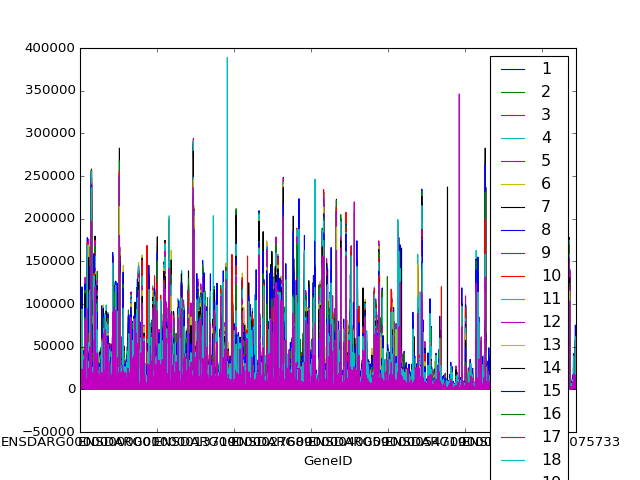

In [17]:
%matplotlib notebook

strata = pd.read_csv("./phylostrata.txt", sep="\t", header=None)
strata.columns = ["GeneID", "ProbeID", "age"]
strata.set_index("ProbeID", inplace=True)
# Loading and formatting phylostrata with matching genes ID and gene age

matched_data = pivoted_samples.join(strata, how="inner").groupby(level=0).last()
# Joining expression data with phylostrata by geneID

unique_data = matched_data.groupby("GeneID").mean()
# Taking the mean expression values for all genes.

char_pd = pd.DataFrame(char, index=char["sample_name"])
mixed = char_pd[char_pd.sex == "mixed"].sample_name.tolist()
mixed += char_pd[char_pd.sex == "female"].sample_name.tolist()

char_pd["timing_number"] = 0
time_stamps = char_pd.time.unique()
for i in xrange(len(time_stamps)):
    char_pd.loc[char_pd.time == time_stamps[i], "timing_number"] = i + 1

    experiment_index = char_pd[char_pd.index.isin(mixed)].reset_index().groupby("timing_number")["index"].apply(
        lambda x: np.array(x))

set_mean = {}
stages = []
for d, col_list in experiment_index.iteritems():
    set_mean[d] = unique_data[col_list].mean(axis=1)
    stages.append(char_pd[char_pd.index.isin(col_list)].stage[0])

mean_data = pd.DataFrame(set_mean)
mean_data.plot()




References: 

Šestak, M. S., Božičević, V., Bakarić, R., Dunjko, V., & Domazet-Lošo, T. (2013). Phylostratigraphic profiles reveal a deep evolutionary history of the vertebrate head sensory systems. Frontiers in Zoology, 10, 18. http://doi.org/10.1186/1742-9994-10-18

Domazet-Lošo T, Tautz D. (2010). A phylogenetically based transcriptome age index mirrors ontogenetic divergence patterns. Nature, 468(7325):815-8. http://doi.org/10.1038/nature09632

Data files: 

Zebrafish expression data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE24616

Phylostrata: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3636138/bin/1742-9994-10-18-S5.xls
